In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from models import NOT_SS
from models import configs
from torch.utils.data import DataLoader
from skimage import measure
from tqdm import tqdm
import json
import time
device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
fwd_config = configs.NOTSS_configs()
fwd_filebase = fwd_config["filebase"]
fwd_args = fwd_config["model_args"]
not_ss = NOT_SS.LoadNOTModel(fwd_filebase, fwd_args)

Total number of parameters of encoder: 553776, 553776 of which are trainable
Total number of parameters of NOT model: 923889, 923889 of which are trainable


In [3]:
train_dataset, test_dataset, strain, sdf_inv_scaler, stress_inv_scaler = configs.LoadDataSS()
strain = strain.to(device)

In [4]:


def predict(data_loader, fwd_model):
    y_pred = []
    y_true = []
    fwd_model = fwd_model.to(device)
    fwd_model.eval()
    with torch.no_grad():
        for data in tqdm(data_loader, desc="Predicting"):
            sdf = data[0].to(device)
            pred = fwd_model(strain, sdf)
            pred = pred.cpu().detach().numpy()
            y_pred.append(pred)
            y_true.append(data[1].cpu().detach().numpy())
        y_true = np.vstack(y_true)
        y_pred = np.vstack(y_pred)
    return y_pred, y_true


def plot_geo_from_sdf(sdf_norm, ax):
    sdf = sdf_inv_scaler(sdf_norm.cpu().detach().numpy())
    sdf = sdf.reshape(120, 120)
    geo = measure.find_contours(
        sdf, 0, positive_orientation='high')
    nx = sdf.shape[0]-1
    for c, contour in enumerate(geo):
        contour = contour*1.2/nx-0.1
        x, y = contour[:, 1], contour[:, 0]
        if c == 0:

            ax.fill(x, y, alpha=1.0, edgecolor="black",
                    facecolor="cyan", label="Outer Boundary")
        else:
            ax.fill(x, y, alpha=1.0, edgecolor="black",
                    facecolor="white", label="Hole")
    ax.set_aspect("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")



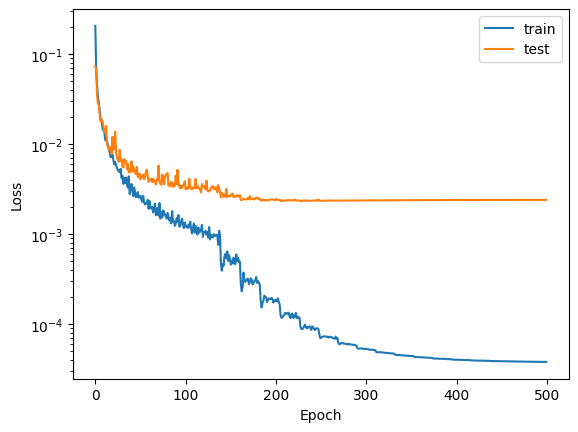

In [5]:
loss_file = fwd_filebase + "/logs.json"
with open(loss_file, 'r') as f:
    data = json.load(f)
plt.plot(data['loss'], label='train')
plt.plot(data['val_loss'], label='test')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [6]:
time_start = time.time()
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
s_pred, s_true = predict(test_loader, not_ss)
s_pred = stress_inv_scaler(s_pred)
s_true = stress_inv_scaler(s_true)
time_end = time.time()
print(
    f"Time taken to predict one sample: {(time_end-time_start)/len(s_pred):.2e} seconds")



Predicting: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s]

Time taken to predict one sample: 1.47e-04 seconds


Mean L2 error of stress: 0.026206111535429955, std: 0.024402203038334846
Index 0 for Best: 14202, error: 0.001791147398762405
Index 1 for 32% percentile: 8119, error: 0.012602302245795727
Index 2 for 64% percentile: 7354, error: 0.025170158594846725
Index 3 for 99% percentile: 10288, error: 0.12403158098459244


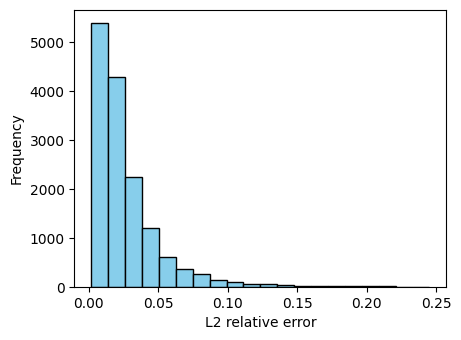

In [8]:
error_s = np.linalg.norm(s_pred-s_true, axis=1) / \
    np.linalg.norm(s_true, axis=1)
mean, std = np.mean(error_s), np.std(error_s)
sort_idx = np.argsort(error_s)
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)

_ = ax.hist(error_s[sort_idx[:-2]], bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")

print(f"Mean L2 error of stress: {mean}, std: {std}")


titles = ["Best", "32% percentile", "64% percentile", "99% percentile"]
min_index = sort_idx[0]
max_index = sort_idx[int(len(sort_idx)*0.99-2)]
median_index = sort_idx[int(len(sort_idx) * 0.32)]
median_index2 = sort_idx[int(len(sort_idx) * 0.64)]
indices = np.array([min_index, median_index, median_index2, max_index])
for i in range(len(indices)):
    print(
        f"Index {i} for {titles[i]}: {indices[i]}, error: {error_s[indices[i]]}")


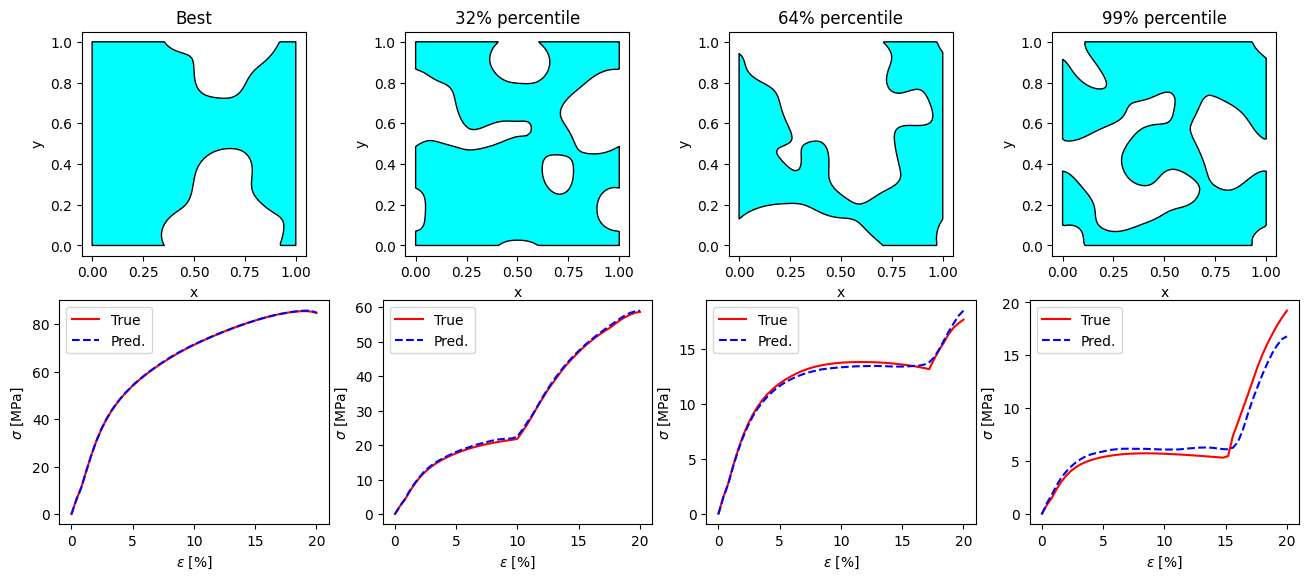

In [16]:
nr, nc = 2, 4
fig = plt.figure(figsize=(nc*4.0, nr*3.2))
strain = np.linspace(0, 0.2, 51)
for ic in range(nc):
    ir = 0
    index = indices[ic]
    s_pred_i = s_pred[index]
    s_true_i = s_true[index]
    sdf_norm = test_dataset[index][0]
    ax = plt.subplot(nr, nc, ic+1)
    plot_geo_from_sdf(sdf_norm, ax)
    ax.set_title(f"{titles[ic]}")
    ax = plt.subplot(nr, nc, ic+nc+1)
    ax.plot(strain*100, s_true_i, 'r', label="True")
    ax.plot(strain*100, s_pred_i, 'b--', label="Pred.")
    ax.set_xlabel(r"$\varepsilon$ [%]")
    ax.set_ylabel(r"$\sigma$ [MPa]")
    ax.legend()
